# 07d Single cell ATAC analysis LT-HSCs

analysis of scATAC seq in LT-HSCs using Signac

used this docker image

docker run \
--rm \
-d \
--name signac \
-p 8880:8888 \
-e JUPYTER_ENABLE_LAB=YES \
-v /Users/efast/Documents/:/home/jovyan/work \
signac_seurat:vs5

In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Mmusculus.v79)
library(ggplot2)
library(JASPAR2018)
library(TFBSTools)
#library(BSgenome.Mmusculus.UCSC.mm10)
library(tidyverse)

set.seed(1234)

Warning message:
“package ‘Seurat’ was built under R version 3.6.2”Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: S4Vectors
Loading req

In [2]:
counts <- Read10X_h5(filename = "./raw_data/ATAC_LT/filtered_peak_bc_matrix.h5")
metadata <- read.csv(
  file = "./raw_data/ATAC_LT/singlecell.csv",
  header = TRUE,
  row.names = 1
)

LT <- CreateSeuratObject(
  counts = counts,
  assay = 'peaks',
  project = 'ATAC',
  min.cells = 1,
  meta.data = metadata
)

Warning message in CreateSeuratObject(counts = counts, assay = "peaks", project = "ATAC", :
"Some cells in meta.data not present in provided counts matrix."

In [3]:
fragment.path <- './raw_data/ATAC_LT/fragments.tsv.gz'

LT <- SetFragments(
  object = LT,
  file = fragment.path
)

In [4]:
LT <- NucleosomeSignal(object = LT)

Extracting reads in requested region
Computing ratio of mononucleosomal to nucleosome-free fragments


Warning message:
"Removed 2 rows containing non-finite values (stat_ydensity)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

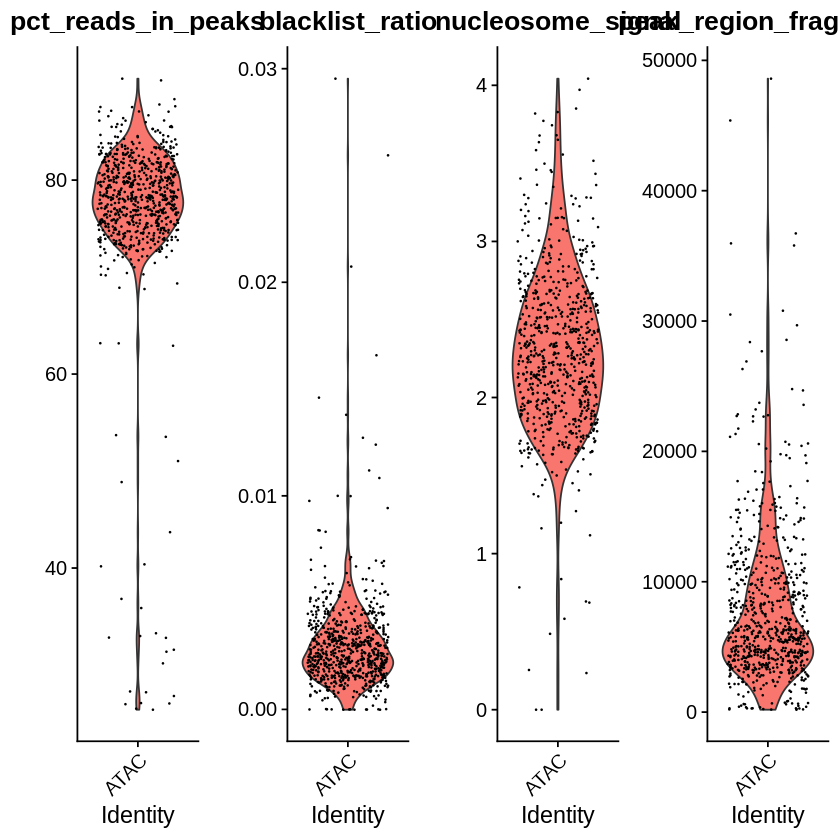

In [5]:
LT$pct_reads_in_peaks <- LT$peak_region_fragments / LT$passed_filters * 100
LT$blacklist_ratio <- LT$blacklist_region_fragments / LT$peak_region_fragments

VlnPlot(
  object = LT,
  features = c('pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_signal', 'peak_region_fragments'),
  pt.size = 0.1,
  ncol = 4) + NoLegend()

Warning message:
"Removed 53 rows containing non-finite values (stat_bin)."Warning message:
"Removed 4 rows containing missing values (geom_bar)."

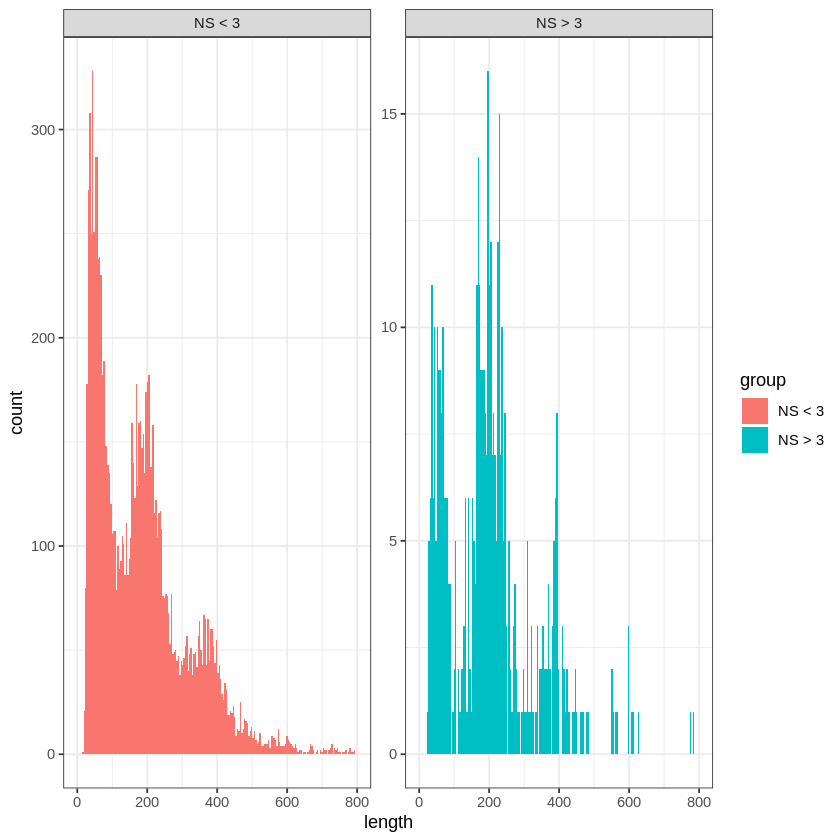

In [6]:
LT$nucleosome_group <- ifelse(LT$nucleosome_signal > 3, 'NS > 3', 'NS < 3')
FragmentHistogram(object = LT, group.by = 'nucleosome_group', region = 'chr1-1-10000000')

In [7]:
# create granges object with TSS positions
gene.ranges <- genes(EnsDb.Mmusculus.v79)
gene.ranges <- gene.ranges[gene.ranges$gene_biotype == 'protein_coding', ]

tss.ranges <- GRanges(
  seqnames = seqnames(gene.ranges),
  ranges = IRanges(start = start(gene.ranges), width = 2),
  strand = strand(gene.ranges)
)

seqlevelsStyle(tss.ranges) <- 'UCSC'
tss.ranges <- keepStandardChromosomes(tss.ranges, pruning.mode = 'coarse')

# to save time use the first 2000 TSSs
LT <- TSSEnrichment(object = LT, tss.positions = tss.ranges[1:2000])

Finding + strand cut sites
Finding - strand cut sites
Computing mean insertion frequency in flanking regions
Normalizing TSS score


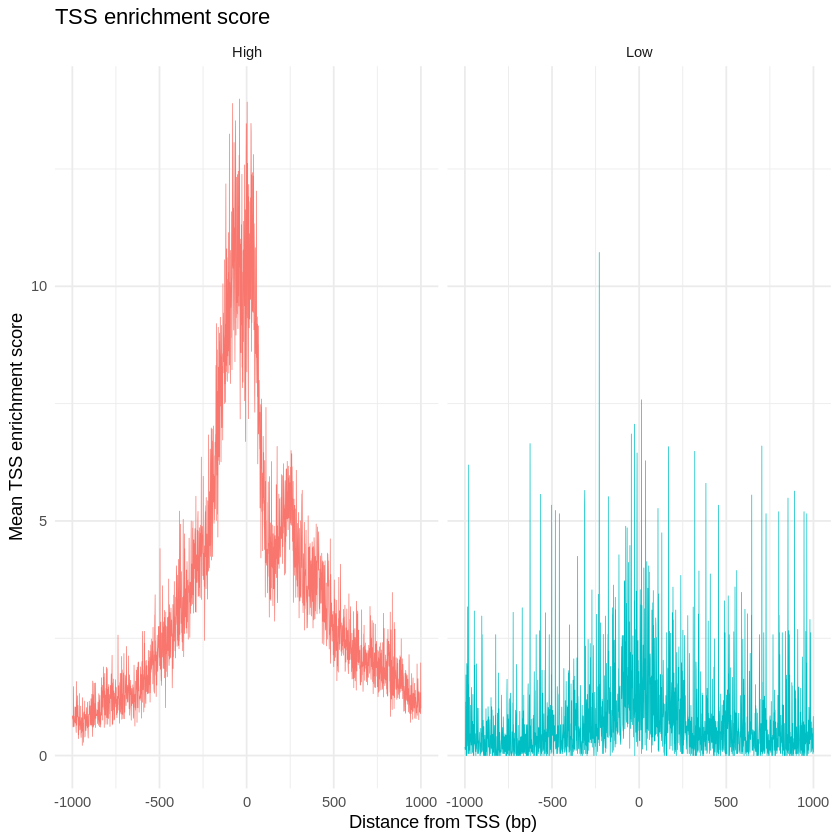

In [8]:
LT$high.tss <- ifelse(LT$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(LT, group.by = 'high.tss') + ggtitle("TSS enrichment score") + NoLegend()

In [9]:
LT <- subset(LT, subset = peak_region_fragments > 1000 & peak_region_fragments < 20000 & pct_reads_in_peaks > 15 & blacklist_ratio < 0.05 & nucleosome_signal < 10 & TSS.enrichment > 2)
LT

An object of class Seurat 
161427 features across 651 samples within 1 assay 
Active assay: peaks (161427 features)

In [10]:
LT <- RunTFIDF(LT)
LT <- FindTopFeatures(LT, min.cutoff = 'q0')
LT <- RunSVD(
  object = LT,
  assay = 'peaks',
  reduction.key = 'LSI_',
  reduction.name = 'lsi'
)

Performing TF-IDF normalization
Running SVD
Scaling cell embeddings


In [11]:
LT <- RunUMAP(object = LT, reduction = 'lsi', dims = 1:30)
LT <- FindNeighbors(object = LT, reduction = 'lsi', dims = 1:30, k.param = 20)
LT <- FindClusters(object = LT, verbose = FALSE, resolution = 0.5, algorithm = 2)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"01:37:31 UMAP embedding parameters a = 0.9922 b = 1.112
01:37:31 Read 651 rows and found 30 numeric columns
01:37:31 Using Annoy for neighbor search, n_neighbors = 30
01:37:31 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
01:37:31 Writing NN index file to temp file /tmp/Rtmpvio8Pv/file1703f4db67e
01:37:31 Searching Annoy index using 1 thread, search_k = 3000
01:37:32 Annoy recall = 100%
01:37:32 Commencing smooth kNN distance calibration using 1 thread
01:37:34 Initializing from normalized Laplacian + noise
01:37:34 Commencing optimization 

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."

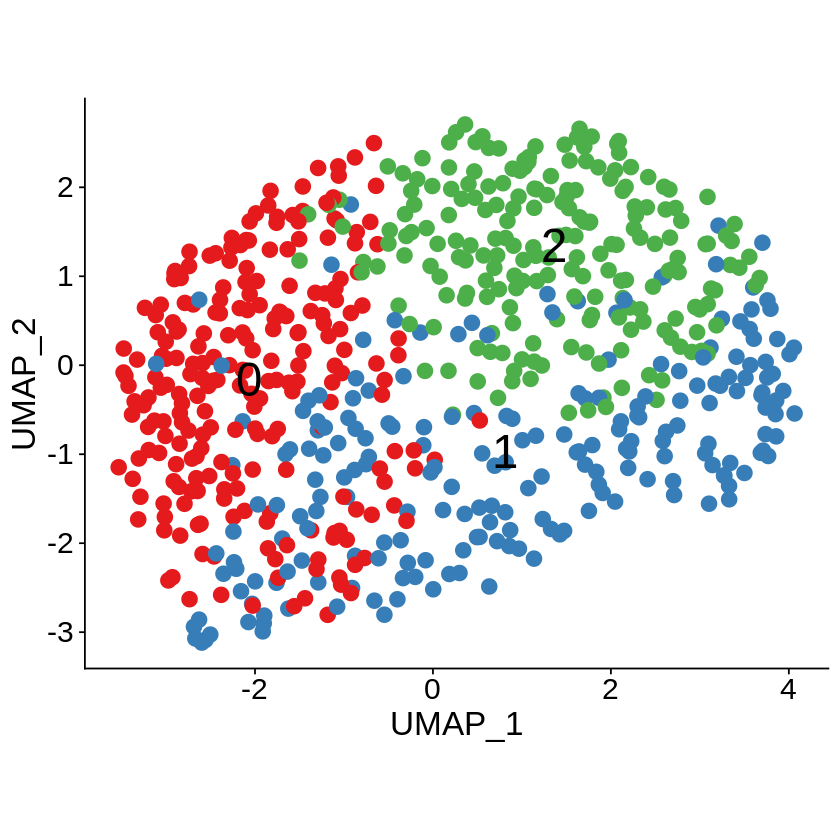

In [12]:
baseplot = DimPlot(object = LT,
                    label = TRUE,
                    cols = c('#E41A1C', '#377EB8', '#4DAF4A'),
                    #cols = 'Set1',
                    pt.size = 4,
                    label.size = 10,
                    #vector.friendly = TRUE
                    
                        )

baseplot + 
FontSize(x.title = 20, y.title = 20) + coord_fixed(ratio = 1) +
theme(axis.text.x = element_text(size=18), axis.text.y = element_text(size=18)) +
NoLegend()

In [13]:
#save plot
ggsave('scATAC_cluster.pdf', plot = last_plot(), device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

Saving 6.67 x 6.67 in image


In [14]:
#save plot
ggsave('scATAC_cluster.png', plot = last_plot(), device = 'png', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

Saving 6.67 x 6.67 in image


In [15]:
# add information about male cells as metainfomation

counts_df <- GetAssayData(object = LT, slot = "counts")
male_counts <- colSums(counts_df[161405:161427,])
LT$male <- male_counts
LT$male_binary <- LT$male
LT$male_binary[LT$male_binary > 0] <- 1

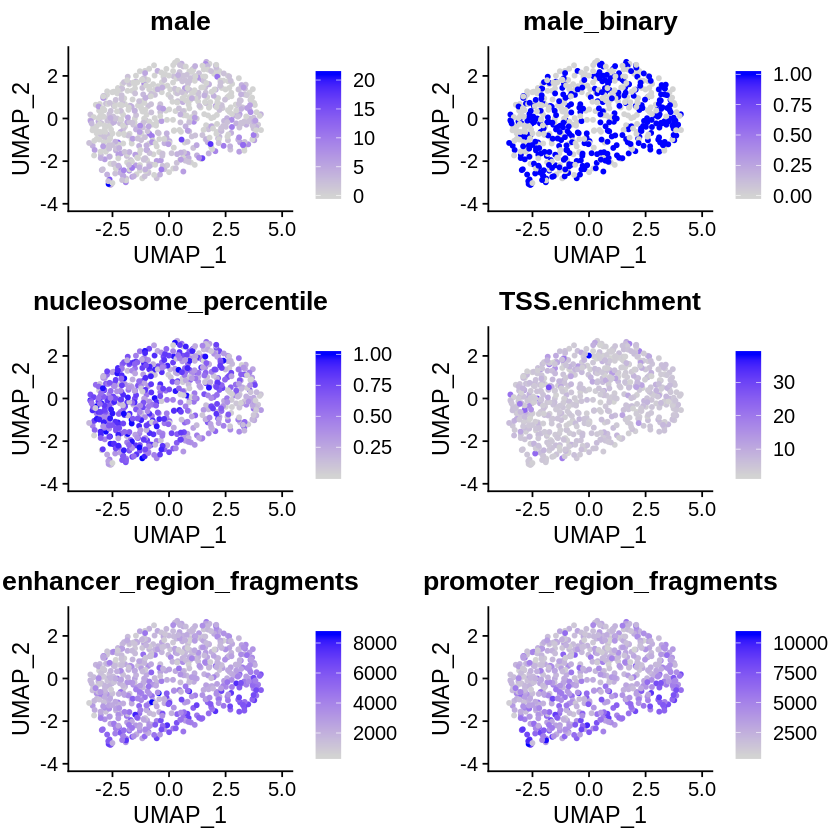

In [16]:
# plot some general stats about cells

FeaturePlot(LT, features = c("male", 
                               "male_binary", 
                               "nucleosome_percentile", 
                               'TSS.enrichment', 
                               'enhancer_region_fragments',
                               'promoter_region_fragments'
                               ), ncol = 2)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


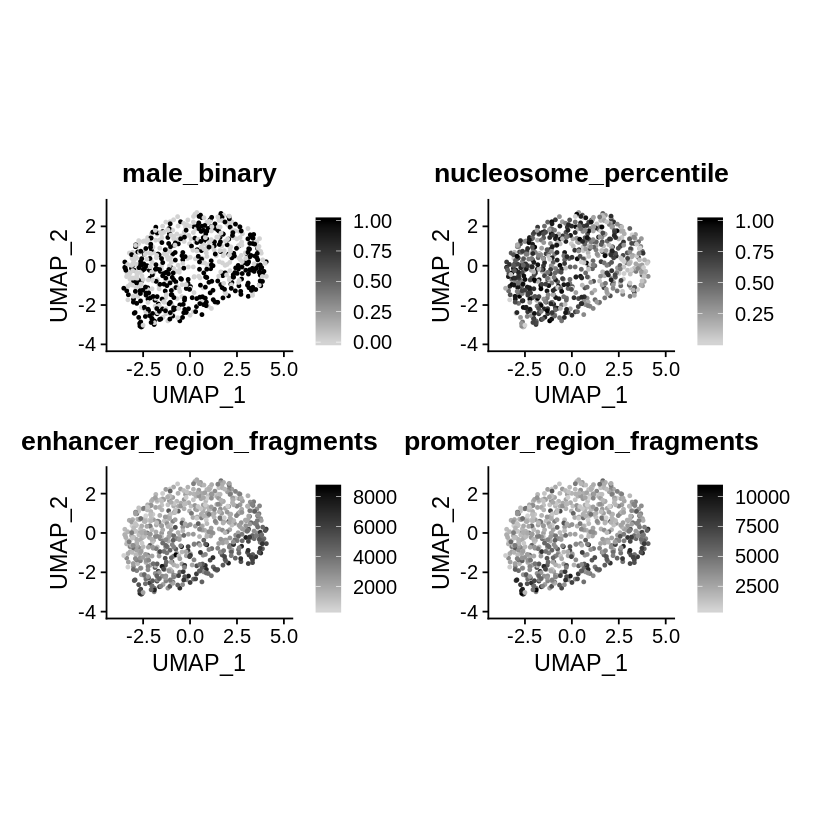

In [17]:
# save some general stats about cells as figure

baseplot = FeaturePlot(LT, features = c("male_binary", 
                               "nucleosome_percentile", 
                               'enhancer_region_fragments',
                               'promoter_region_fragments'
                               ), 
                              cols = c('lightgrey', 'black'),
                              pt.size = 0.7,
                              
                              )

baseplot + coord_fixed(ratio = 0.7) 

In [18]:
#save plot
ggsave('scATAC_LT_generalstats.pdf', plot = last_plot(), device = 'pdf', width = 8, height = 6.67, path = './figures/',
       scale = 1, units = 'in', dpi = 300)

In [19]:
#extract gene coordinates from Ensembl, and ensure name formatting is consistent with  Seurat object 


gene.coords <- genes(EnsDb.Mmusculus.v79, filter = ~ gene_biotype == "protein_coding")
seqlevelsStyle(gene.coords) <- 'UCSC'
genebody.coords <- keepStandardChromosomes(gene.coords, pruning.mode = 'coarse')
genebodyandpromoter.coords <- Extend(x = gene.coords, upstream = 2000, downstream = 0)

# build a gene by cell matrix
gene.activities <- FeatureMatrix(
  fragments = fragment.path,
  features = genebodyandpromoter.coords,
  cells = colnames(LT),
  chunk = 10
)

# convert rownames from chromsomal coordinates into gene names
gene.key <- genebodyandpromoter.coords$gene_name
names(gene.key) <- GRangesToString(grange = genebodyandpromoter.coords)
rownames(gene.activities) <- make.unique(gene.key[rownames(gene.activities)])
gene.activities <- gene.activities[rownames(gene.activities)!="",]

#Add the gene activity matrix to the Seurat object as a new assay, and normalize it
LT[['RNA']] <- CreateAssayObject(counts = gene.activities)
LT <- NormalizeData(
  object = LT,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(LT$nCount_RNA)
)

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 3 out-of-bound ranges located on sequences
  JH584293.1, JH584295.1, and JH584296.1. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information."Extracting reads overlapping genomic regions
Constructing matrix


In [20]:
DefaultAssay(LT) <- 'RNA'
LT.markers <- FindAllMarkers(LT, only.pos = TRUE, min.pct = 0.10, logfc.threshold = 0.20)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2


In [21]:
LT.markers

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
Jun,3.205283e-05,0.2537235,0.701,0.688,0.658301002,0,Jun
Nfe2l3,1.270919e-03,0.2233480,0.320,0.238,1.000000000,0,Nfe2l3
Ric8b,1.552772e-03,0.2163425,0.506,0.460,1.000000000,0,Ric8b
Golgb1,2.275337e-03,0.2095079,0.515,0.464,1.000000000,0,Golgb1
Ddx5,2.784917e-03,0.2227728,0.498,0.448,1.000000000,0,Ddx5
Polg2,4.727499e-03,0.2417633,0.489,0.469,1.000000000,0,Polg2
Fosb,6.780730e-03,0.2127249,0.528,0.500,1.000000000,0,Fosb
Sptb,3.508997e-05,0.2266290,0.660,0.376,0.720677708,1,Sptb
Abi3,1.318268e-07,0.3090602,0.663,0.558,0.002707458,2,Abi3


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


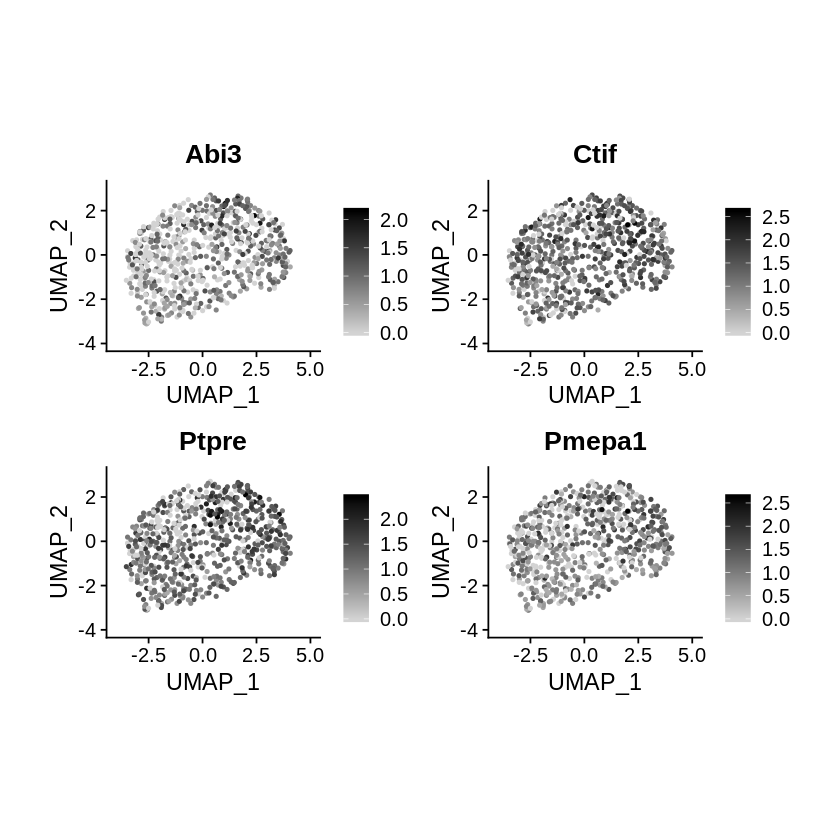

In [32]:
DefaultAssay(LT) <- 'RNA'

baseplot2 = FeaturePlot(LT, features = c('Abi3', 'Ctif', 'Ptpre', 'Pmepa1'
                               ), 
                              cols = c('lightgrey', 'black'),
                              pt.size = 0.8,
                              ncol = 2)

baseplot2 + coord_fixed(ratio = 0.75)  

In [33]:
#save plot
ggsave('scATAC_LT_4promotor.pdf', plot = last_plot(), device = 'pdf', width = 7.5, height = 6.67, path = './figures/',
       scale = 1, units = 'in', dpi = 300)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


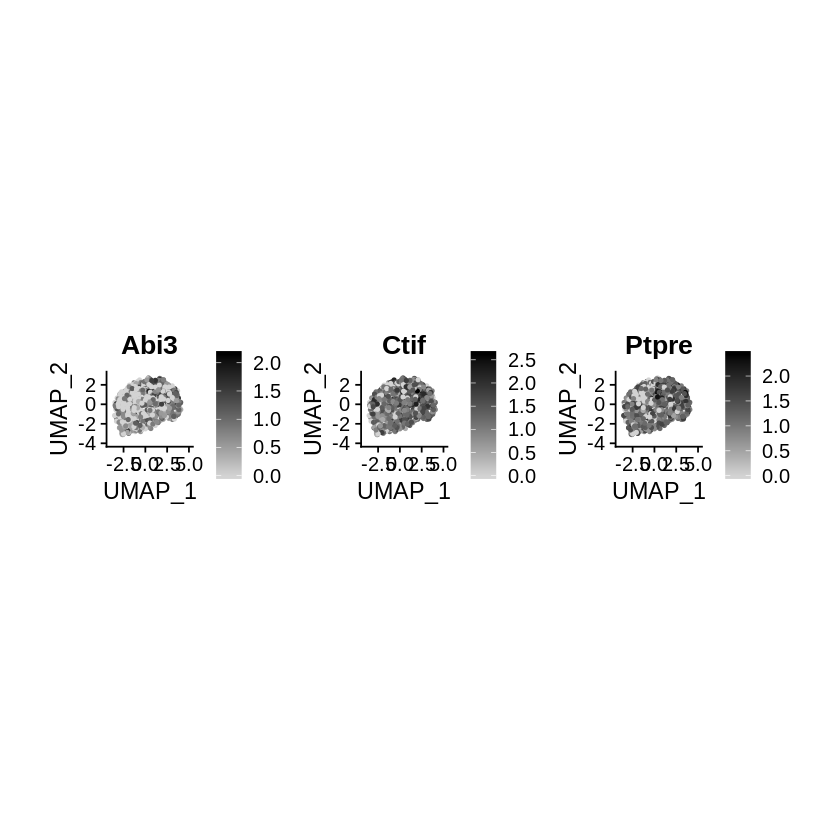

In [38]:
DefaultAssay(LT) <- 'RNA'

baseplot2 = FeaturePlot(LT, features = c('Abi3', 'Ctif', 'Ptpre'
                               ), 
                              cols = c('lightgrey', 'black'),
                              pt.size = 0.8,
                              ncol = 3)

baseplot2 + coord_fixed(ratio = 0.25)  

In [39]:
#save plot
ggsave('scATAC_LT_3promotor.pdf', plot = last_plot(), device = 'pdf', width = 12, height = 6, path = './figures/',
       scale = 1, units = 'in', dpi = 300)

### compare the clusters to each other

In [40]:
RNA_0vs2 <- FindMarkers(
  object = LT,
  ident.1 = '0',
  ident.2 = '2',
  only.pos = FALSE,
  min.pct = 0.1
)


RNA_1vs2 <- FindMarkers(
  object = LT,
  ident.1 = '1',
  ident.2 = '2',
  only.pos = FALSE,
  min.pct = 0.1
)

#there was no difference bettween 0 and 1

In [41]:
head(RNA_0vs2)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Abi3,2.931615e-09,-0.3649213,0.433,0.663,0.0000602095
Ctif,1.964606e-08,-0.3084745,0.797,0.894,0.0004034907
Ptpre,8.304832e-08,-0.3279299,0.732,0.851,0.0017056465
Gngt2,1.434447e-06,-0.2535974,0.247,0.442,0.0294606813
Nfe2l3,3.592746e-06,0.2700295,0.320,0.139,0.0737878252
Pmepa1,3.765079e-06,-0.3214792,0.632,0.755,0.0773271955


In [42]:
head(RNA_1vs2)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pmepa1,0.000510989,-0.2852036,0.854,0.755,1
Abi3,0.001407836,-0.2515476,0.693,0.663,1


### look at differentially accessible peaks

In [43]:
DefaultAssay(LT) <- 'peaks'

da_peaks_0vs1 <- FindMarkers(
  object = LT,
  ident.1 = '0', 
  ident.2 = '1',
  min.pct = 0.1,
  only.pos = FALSE,
  test.use = 'LR',
  latent.vars = 'peak_region_fragments'
)

da_peaks_0vs2 <- FindMarkers(
  object = LT,
  ident.1 = '0', 
  ident.2 = '2',
  min.pct = 0.1,
  only.pos = FALSE,
  test.use = 'LR',
  latent.vars = 'peak_region_fragments'
)

da_peaks_1vs2 <- FindMarkers(
  object = LT,
  ident.1 = '1', 
  ident.2 = '2',
  min.pct = 0.1,
  only.pos = FALSE,
  test.use = 'LR',
  latent.vars = 'peak_region_fragments'
)

print('0vs1_up_1')
print((da_peaks_0vs1) %>% filter(avg_logFC < 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))
print('0vs1_up_0')
print((da_peaks_0vs1) %>% filter(avg_logFC > 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))

print('0vs2_up_2')
print((da_peaks_0vs2) %>% filter(avg_logFC < 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))
print('0vs2_up_0')
print((da_peaks_0vs2) %>% filter(avg_logFC > 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))

print('1vs2_up_1')
print((da_peaks_1vs2) %>% filter(avg_logFC > 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))
print('1vs2_up_2')
print((da_peaks_1vs2) %>% filter(avg_logFC < 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))

[1] "0vs1_up_1"
  n
1 0
[1] "0vs1_up_0"
  n
1 0
[1] "0vs2_up_2"
  n
1 3
[1] "0vs2_up_0"
  n
1 7
[1] "1vs2_up_1"
  n
1 0
[1] "1vs2_up_2"
  n
1 0


In [44]:
#10 regions that are specifically enriched
(da_peaks_0vs2)[1:10,]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6:51452322-51461116,1.619399e-13,0.7105801,0.303,0.053,2.614148e-08
chr19:5792802-5804993,1.280382e-11,0.3367027,0.658,0.404,2.066883e-06
chr3:8765909-8768208,2.374768e-11,-0.5151341,0.169,0.433,3.833517e-06
chr7:19286173-19310836,1.004336e-10,0.3110097,0.714,0.500,1.621270e-05
chr11:116011224-116025071,1.590159e-10,0.2847302,0.727,0.500,2.566946e-05
chr15:74988133-74990159,3.377703e-09,-0.5050549,0.108,0.312,5.452524e-04
chr18:34858588-34869147,1.731474e-08,0.2757201,0.649,0.466,2.795067e-03
chr11:95833704-95836090,5.654685e-08,-0.3573069,0.251,0.481,9.128188e-03
chr11:106766482-106790961,6.710241e-08,0.2679771,0.697,0.543,1.083214e-02


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


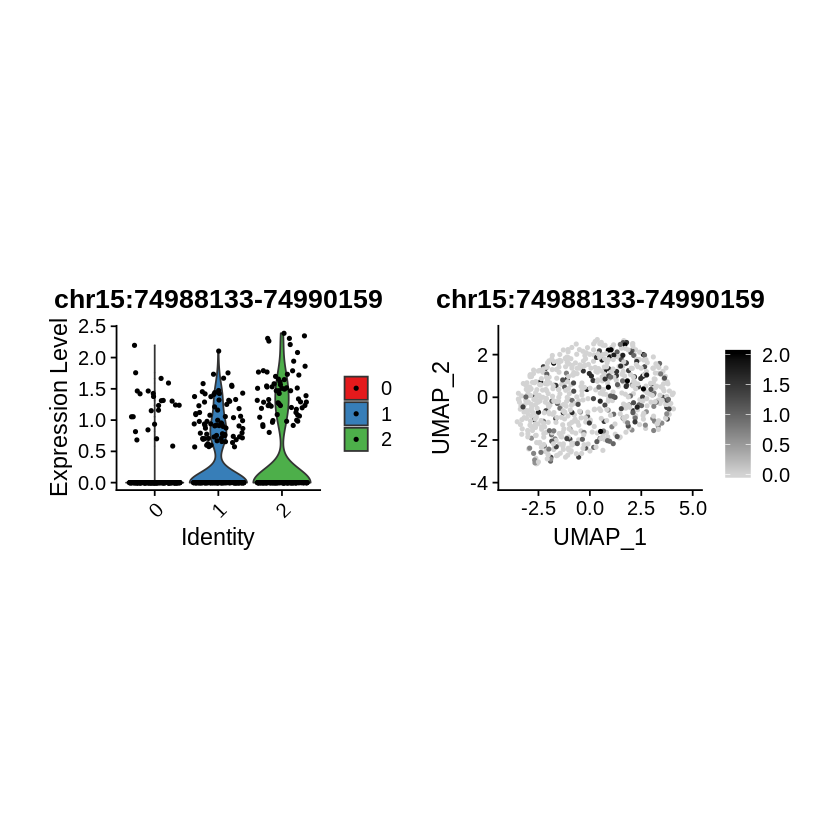

In [45]:
plot1 <- VlnPlot(
  object = LT,
  features = rownames(da_peaks_0vs2)[6],
  ncol = 2,
  pt.size = 0.8,
  cols = c('#E41A1C', '#377EB8', '#4DAF4A'),
  idents = c("0","1","2")
)

plot2 <- FeaturePlot(
  object = LT,
  features = rownames(da_peaks_0vs2)[6],
  ncol = 2,
  pt.size = 0.8,
  cols = c('lightgrey', 'black'),
  #cols = c("lightgrey",  "red"),
  max.cutoff = 'q95'
)

CombinePlots(list(plot1,plot2))  + coord_fixed(ratio = 0.37)

In [46]:
#save plot
ggsave('scATAC_violin_peaks_Ly6ai_up2.pdf', plot = last_plot(), width =  7.5, height =  6.67, device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


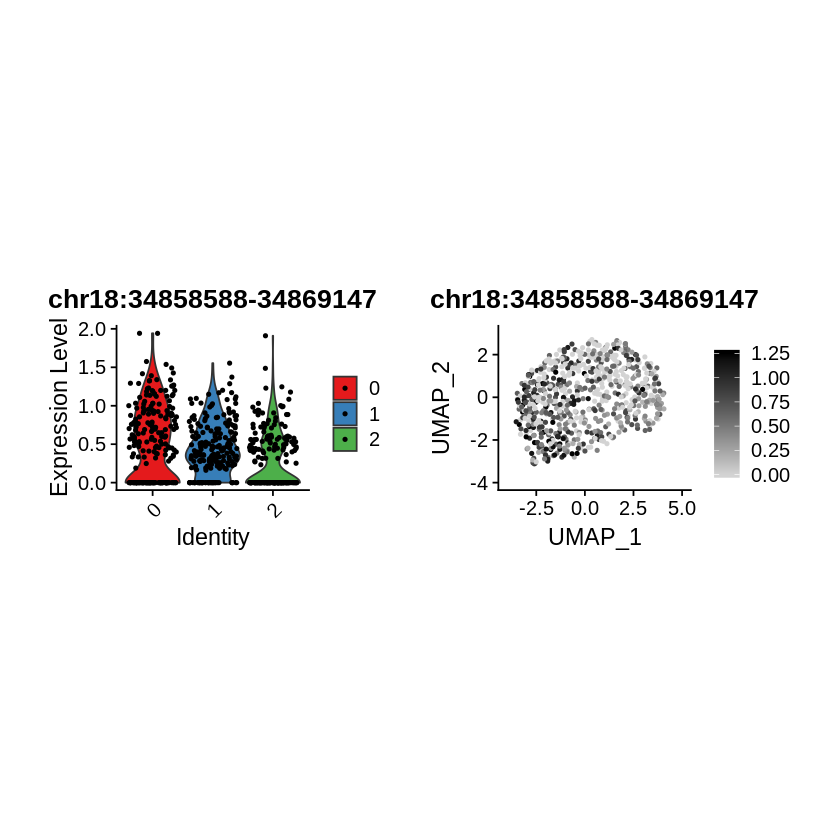

In [47]:
plot1 <- VlnPlot(
  object = LT,
  features = rownames(da_peaks_0vs2)[7],
  ncol = 2,
  pt.size = 0.8,
  cols = c('#E41A1C', '#377EB8', '#4DAF4A'),
  idents = c("0","1","2")
)

plot2 <- FeaturePlot(
  object = LT,
  features = rownames(da_peaks_0vs2)[7],
  ncol = 2,
  pt.size = 0.8,
  cols = c('lightgrey', 'black'),
  #cols = c("lightgrey",  "red"),
  max.cutoff = 'q95'
)

CombinePlots(list(plot1,plot2))  + coord_fixed(ratio = 0.37)

In [48]:
#save plot
ggsave('scATAC_violin_peaks_Egr1_up0.pdf', plot = last_plot(), width =  7.5, height =  6.67, device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

In [49]:
open_0 <- rownames(da_peaks_0vs2[da_peaks_0vs2$avg_logFC < -0.25, ])
open_2 <- rownames(da_peaks_0vs2[da_peaks_0vs2$avg_logFC > 0.25, ])
closest_0 <- ClosestFeature(regions = open_0, annotation = EnsDb.Mmusculus.v79, sep = c(':', '-'))
closest_2 <- ClosestFeature(regions = open_2, annotation = EnsDb.Mmusculus.v79, sep = c(':', '-'))
head(closest_2)

Warning message in if (seqlevelsStyle(x = regions) != seqlevelsStyle(x = annotation)) {:
"the condition has length > 1 and only the first element will be used"Warning message in if (seqlevelsStyle(x = regions) != seqlevelsStyle(x = annotation)) {:
"the condition has length > 1 and only the first element will be used"

,gene_id,gene_name,gene_biotype,seq_coord_system,symbol,entrezid,closest_region,query_region,distance
,<chr>,<chr>,<chr>,<chr>,<chr>,<I<named list>>,<chr>,<chr>,<int>
ENSMUSG00000004980,ENSMUSG00000004980,Hnrnpa2b1,protein_coding,chromosome,Hnrnpa2b1,"53379, 1....",chr6:51460434-51469894,chr6:51452322-51461116,0
ENSMUSG00000024941,ENSMUSG00000024941,Scyl1,protein_coding,chromosome,Scyl1,78891,chr19:5758427-5771401,chr19:5792802-5804993,21400
ENSMUSG00000003545,ENSMUSG00000003545,Fosb,protein_coding,chromosome,Fosb,14282,chr7:19302721-19310045,chr7:19286173-19310836,0
ENSMUSG00000016559,ENSMUSG00000016559,H3f3b,protein_coding,chromosome,H3f3b,NA,chr11:116021912-116027962,chr11:116011224-116025071,0
ENSMUSG00000038418,ENSMUSG00000038418,Egr1,protein_coding,chromosome,Egr1,13653,chr18:34859823-34864984,chr18:34858588-34869147,0
ENSMUSG00000018372,ENSMUSG00000018372,Cep95,protein_coding,chromosome,Cep95,320162,chr11:106789252-106819930,chr11:106766482-106790961,0


In [50]:
head(closest_0)

,gene_id,gene_name,gene_biotype,seq_coord_system,symbol,entrezid,closest_region,query_region,distance
,<chr>,<chr>,<chr>,<chr>,<chr>,<I<named list>>,<chr>,<chr>,<int>
ENSMUSG00000040269,ENSMUSG00000040269,Mrps28,protein_coding,chromosome,Mrps28,66230,chr3:8802146-8923918,chr3:8765909-8768208,33937
ENSMUSG00000022586,ENSMUSG00000022586,Ly6i,protein_coding,chromosome,Ly6i,57248,chr15:74979534-74983430,chr15:74988133-74990159,4702
ENSMUSG00000018381,ENSMUSG00000018381,Abi3,protein_coding,chromosome,Abi3,66610,chr11:95830074-95842476,chr11:95833704-95836090,0
ENSMUSG00000034168,ENSMUSG00000034168,Irf2bpl,protein_coding,chromosome,Irf2bpl,238330,chr12:86880703-86884814,chr12:86831683-86835071,45631
ENSMUSG00000033510,ENSMUSG00000033510,Otud7a,protein_coding,chromosome,Otud7a,170711,chr7:63444751-63759028,chr7:63814805-63817911,55776
ENSMUSG00000074794,ENSMUSG00000074794,Arrdc3,protein_coding,chromosome,Arrdc3,105171,chr13:80883384-80896035,chr13:80899460-80900871,3424


In [51]:
# overlap the peaks and the mapping to genes file to save later

peaks_all_df <- (da_peaks_0vs2[da_peaks_0vs2$p_val_adj < 0.05, ])
peaks_all <- rownames(peaks_all_df)
closest_all <- ClosestFeature(regions = peaks_all, annotation = EnsDb.Mmusculus.v79, sep = c(':', '-'))
peaks_all_df$query_region <- rownames(peaks_all_df) # makes index to column
peaks_all_df <- merge(peaks_all_df, closest_all, by = 'query_region')

Warning message in if (seqlevelsStyle(x = regions) != seqlevelsStyle(x = annotation)) {:
"the condition has length > 1 and only the first element will be used"

#### played around with the options for a bit - wasn't that clear to figure out - decided to manipulated in illustrtor

FontSize(x.title = 20, y.title = 20) + coord_fixed(ratio = 1) +
theme(axis.text.x = element_text(size=18), axis.text.y = element_text(size=18)) +
NoLegend()

Warning message:
"Removed 1 rows containing missing values (position_stack)."

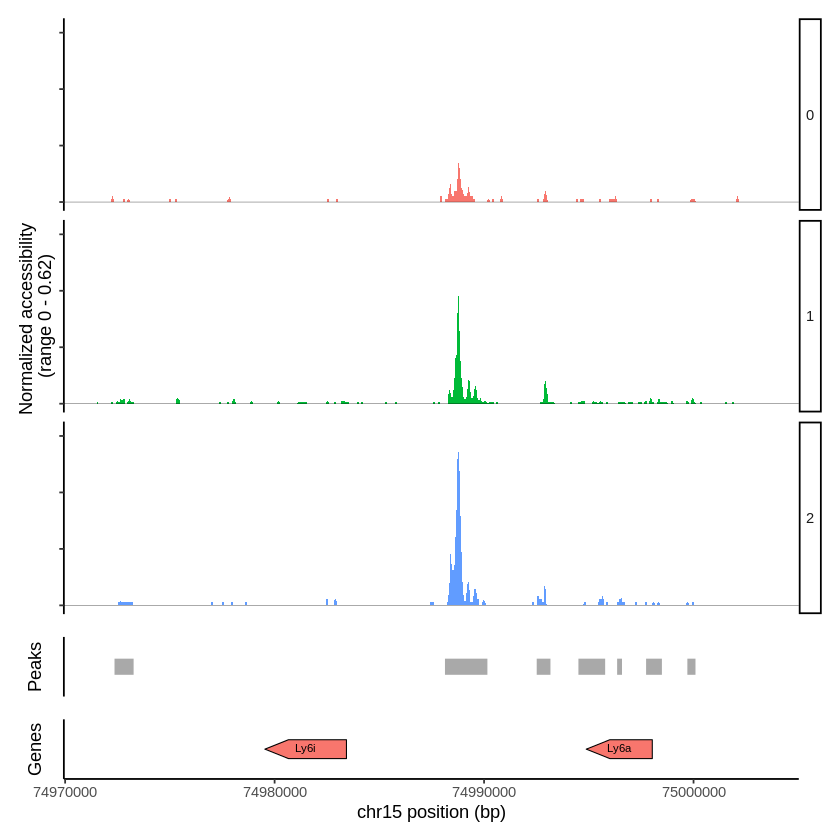

In [52]:
region1 <- GRangesToString(subset(gene.coords, symbol=="Ly6i"))

plot = CoveragePlot(
  object = LT,
  region = region1,
  sep = c(":", "-"),
  annotation = EnsDb.Mmusculus.v79,
  peaks = StringToGRanges(regions = rownames(LT), sep = c(":", "-")),
  extend.upstream = 8000,
  extend.downstream = 20000
) 
plot

In [53]:
ggsave('scATAC_coverage_Ly6a.pdf', plot = last_plot(), width = 5, height = 3, device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

Warning message:
"Removed 1 rows containing missing values (position_stack)."

Warning message:
"Removed 1436 rows containing missing values (position_stack)."Warning message:
"Removed 90 rows containing missing values (position_stack)."

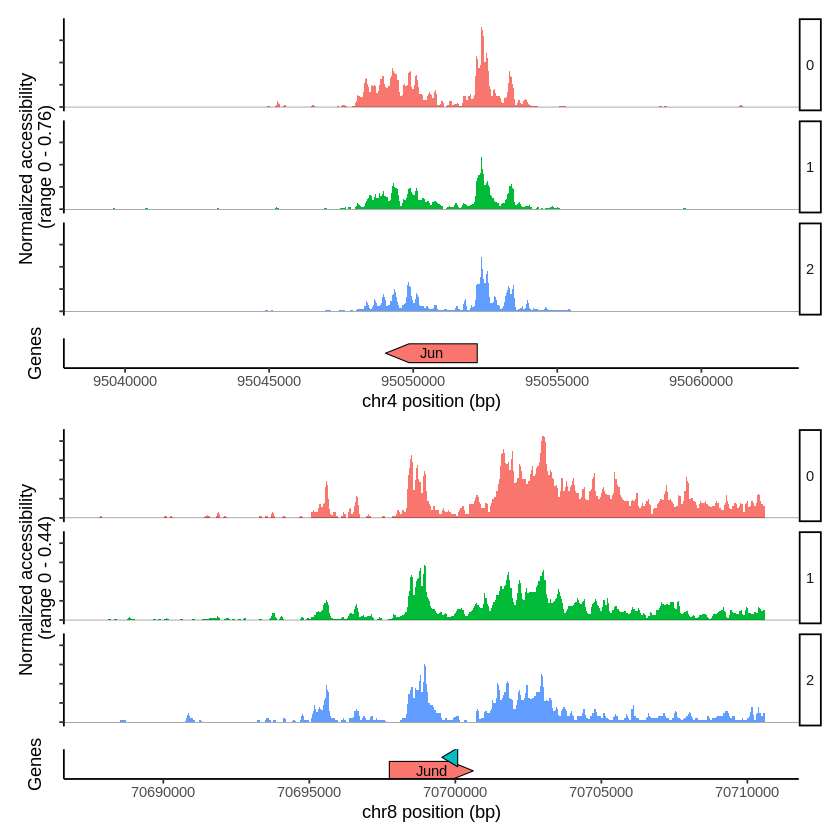

In [54]:
# set plotting order
levels(LT) <- c('0','1','2')

region1 <- GRangesToString(subset(gene.coords, symbol=="Jun"))
region2 <- GRangesToString(subset(gene.coords, symbol=="Jund"))

CoveragePlot(
  object = LT,
  region = c(region1, region2),
  sep = c(":", "-"),
  annotation = EnsDb.Mmusculus.v79,
  #peaks = StringToGRanges(regions = rownames(LT), sep = c(":", "-")),
  peaks = NULL,
  extend.upstream = 10000,
  extend.downstream = 10000,
  ncol = 1
)

In [55]:
ggsave('scATAC_coverage_Jund_Jun.pdf', plot = last_plot(), device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

Saving 6.67 x 6.67 in image
Warning message:
"Removed 1436 rows containing missing values (position_stack)."Warning message:
"Removed 90 rows containing missing values (position_stack)."

Warning message:
"Removed 674 rows containing missing values (position_stack)."Warning message:
"Removed 489 rows containing missing values (position_stack)."

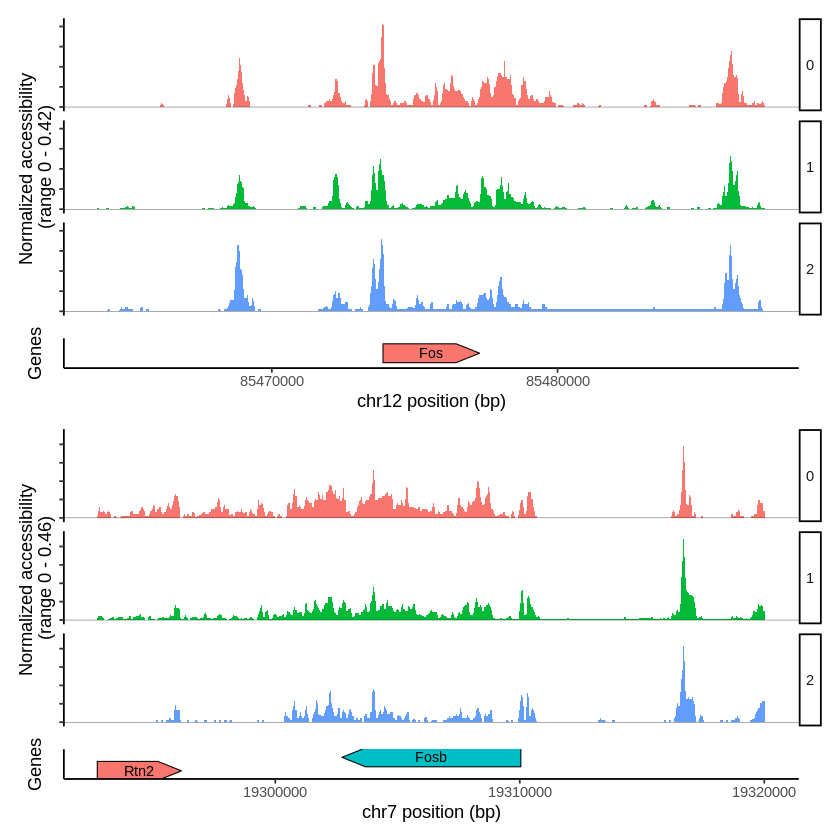

In [56]:
# set plotting order
levels(LT) <- c('0','1','2')

region1 <- GRangesToString(subset(gene.coords, symbol=="Fos"))
region2 <- GRangesToString(subset(gene.coords, symbol=="Fosb"))

CoveragePlot(
  object = LT,
  region = c(region1, region2),
  sep = c(":", "-"),
  annotation = EnsDb.Mmusculus.v79,
  #peaks = StringToGRanges(regions = rownames(LT), sep = c(":", "-")),
  extend.upstream = 10000,
  extend.downstream = 10000,
  ncol = 1
)

In [57]:
ggsave('scATAC_coverage_Fos_Fosb.pdf', plot = last_plot(), device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

Saving 6.67 x 6.67 in image
Warning message:
"Removed 674 rows containing missing values (position_stack)."Warning message:
"Removed 489 rows containing missing values (position_stack)."

Warning message:
"Removed 1501 rows containing missing values (position_stack)."Warning message:
"Removed 1 rows containing missing values (geom_segment)."

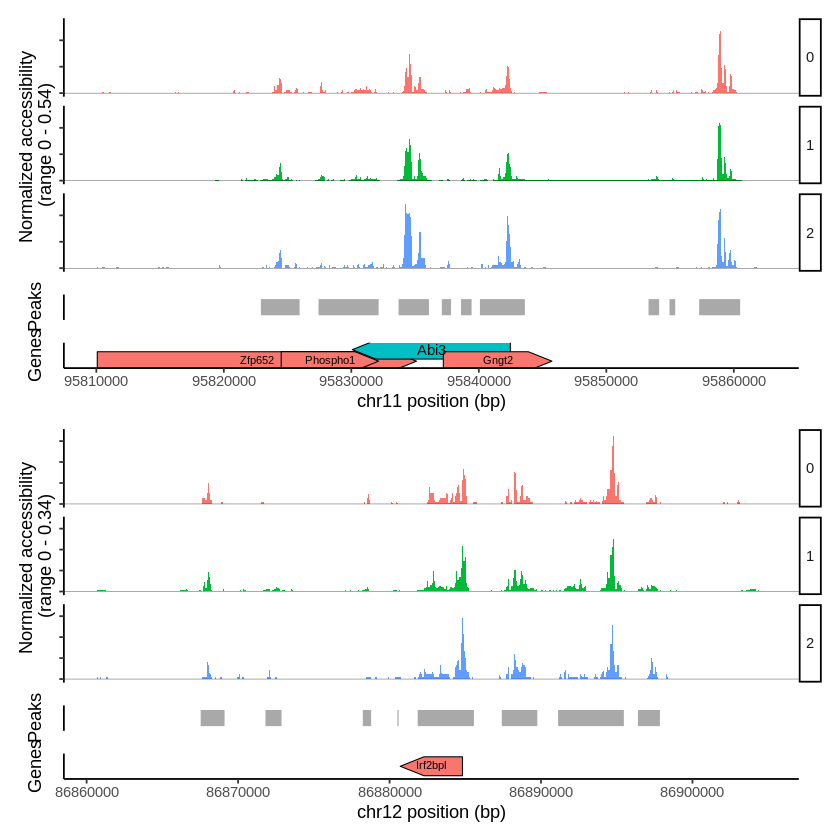

In [58]:
# set plotting order
levels(LT) <- c('0','1','2')

region1 <- GRangesToString(subset(gene.coords, symbol=="Abi3"))
region2 <- GRangesToString(subset(gene.coords, symbol=="Irf2bpl"))

CoveragePlot(
  object = LT,
  region = c(region1, region2),
  sep = c(":", "-"),
  annotation = EnsDb.Mmusculus.v79,
  peaks = StringToGRanges(regions = rownames(LT), sep = c(":", "-")),
  extend.upstream = 20000,
  extend.downstream = 20000,
  ncol = 1
)

Warning message:
"Removed 865 rows containing missing values (position_stack)."Warning message:
"Removed 1 rows containing missing values (geom_segment)."Warning message:
"Removed 2587 rows containing missing values (position_stack)."Warning message:
"Removed 1 rows containing missing values (geom_segment)."

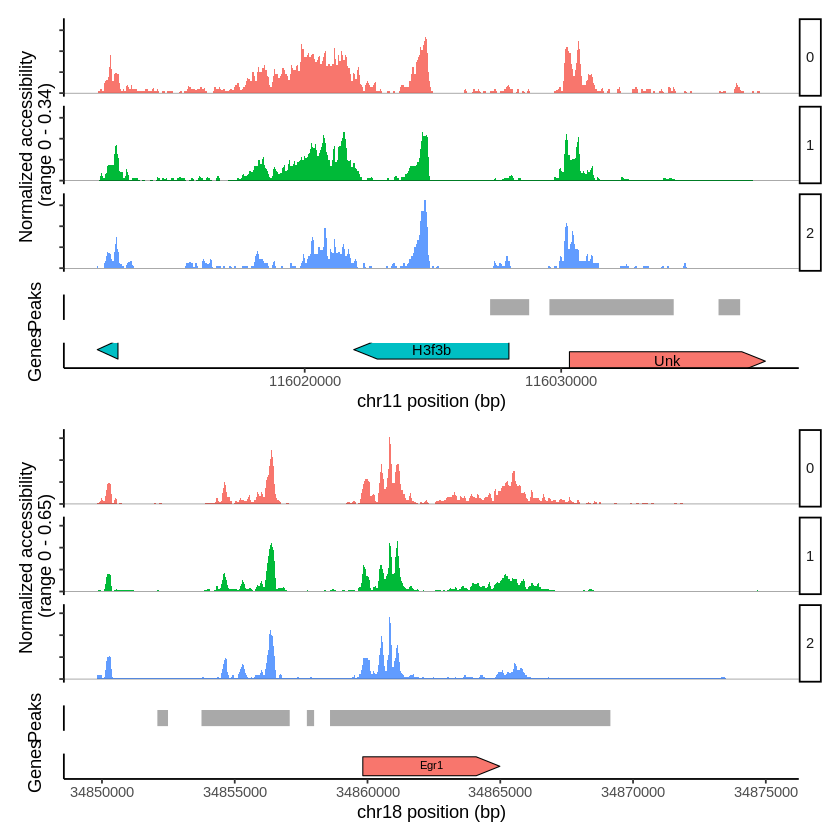

In [59]:
# set plotting order
levels(LT) <- c('0','1','2')

region1 <- GRangesToString(subset(gene.coords, symbol=="H3f3b"))
region2 <- GRangesToString(subset(gene.coords, symbol=="Egr1"))

CoveragePlot(
  object = LT,
  region = c(region1, region2),
  sep = c(":", "-"),
  annotation = EnsDb.Mmusculus.v79,
  peaks = StringToGRanges(regions = rownames(LT), sep = c(":", "-")),
  extend.upstream = 10000,
  extend.downstream = 10000,
  ncol = 1
)

Warning message:
"Removed 826 rows containing missing values (position_stack)."Warning message:
"Removed 1 rows containing missing values (geom_segment)."

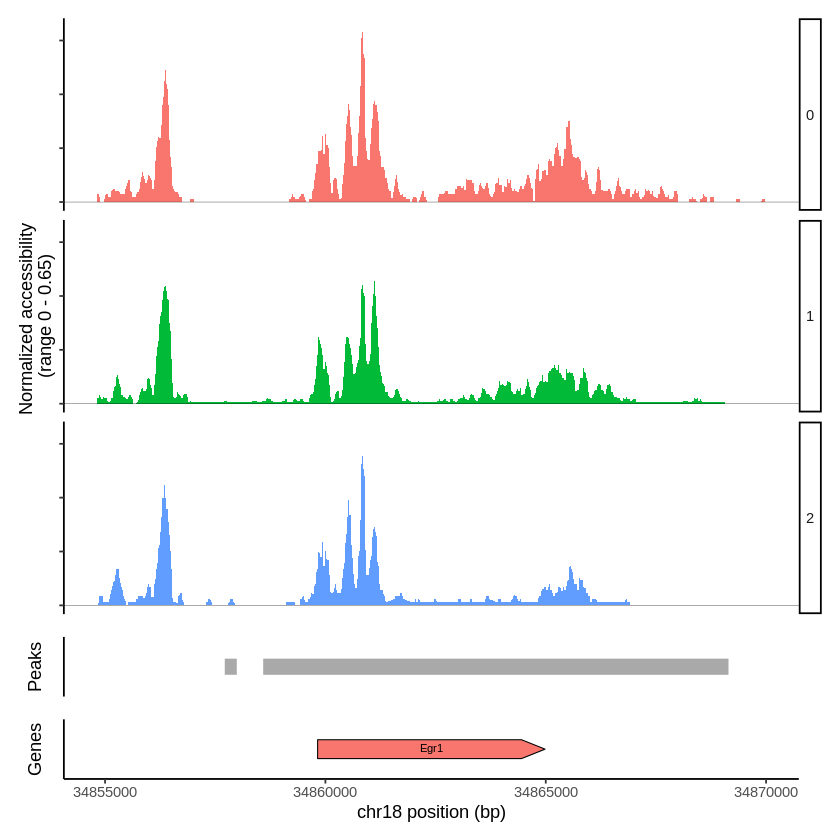

In [60]:
CoveragePlot(
  object = LT,
  region = GRangesToString(subset(gene.coords, symbol=="Egr1")),
  sep = c(":", "-"),
  annotation = EnsDb.Mmusculus.v79,
  peaks = StringToGRanges(regions = rownames(LT), sep = c(":", "-")),
  extend.upstream = 5000,
  extend.downstream = 5000,
  #height.tracks = 20,
  ncol = 1
)

In [61]:
ggsave('scATAC_coverage_Egr1.pdf', plot = last_plot(), width = 5, height = 3, device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

Warning message:
"Removed 826 rows containing missing values (position_stack)."Warning message:
"Removed 1 rows containing missing values (geom_segment)."

## chromVar

In [62]:
# Get a list of motif position frequency matrices from the JASPAR database
DefaultAssay(LT) <- 'peaks'
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)

# Scan the DNA sequence of each peak for the presence of each motif
motif.matrix <- CreateMotifMatrix(
  features = StringToGRanges(rownames(LT), sep = c(":", "-")),
  pwm = pfm,
  genome = 'mm10',
  sep = c(":", "-"),
  use.counts = FALSE
)

# Create a new Mofif object to store the results
motif <- CreateMotifObject(
  data = motif.matrix,
  pwm = pfm
)

# Add the Motif object to the assay
LT[['peaks']] <- AddMotifObject(
  object = LT[['peaks']],
  motif.object = motif
)

# calculates sequence statistics for motif enrichment

LT <- RegionStats(
  object = LT,
  genome = BSgenome.Mmusculus.UCSC.mm10,
  sep = c(":", "-")
)


Attaching package: 'XVector'

The following object is masked from 'package:purrr':

    compact


Attaching package: 'Biostrings'

The following object is masked from 'package:base':

    strsplit



In [63]:
# run ChromVAR
LT <- RunChromVAR(
  object = LT,
  genome = BSgenome.Mmusculus.UCSC.mm10
)
DefaultAssay(LT) <- 'chromvar'

Computing GC bias per region
Selecting background regions
Computing motif deviations from background
Constructing chromVAR assay


In [64]:
# calculate motif enrichment for each cluster


LT.markers_cv <- FindAllMarkers(LT, only.pos = TRUE, min.pct = 0.10, logfc.threshold = 0.25)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2


In [65]:
motifnames <- GetMotifData(object = LT, assay = 'peaks', slot = 'motif.names')
motifnames <- t(as.data.frame((motifnames)))
colnames(motifnames) <- c("gene_name")
motifnames <- data.frame(gene = row.names(motifnames), motifnames)
LT.markers_cv <- merge(LT.markers_cv, motifnames, by = 'gene')

In [66]:
LT.markers_cv %>% filter(p_val_adj < 0.001) %>% filter(cluster == 0) 

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0131.2,3.858128e-14,0.3906418,0.658,0.386,1.743874e-11,0,HINFP
MA0470.1,1.856389e-14,0.3351147,0.597,0.348,8.390877e-12,0,E2F4
MA0506.1,1.622248e-15,0.5017814,0.593,0.355,7.332559e-13,0,NRF1
MA0527.1,8.199310e-08,0.3717773,0.567,0.386,3.706088e-05,0,ZBTB33
MA1122.1,1.287126e-16,0.3282769,0.636,0.360,5.817810e-14,0,TFDP1


In [67]:
head(LT.markers_cv %>% filter(p_val_adj < 0.001) %>% filter(cluster == 1))

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0037.3,2.153109e-06,0.8756412,0.585,0.446,9.732051e-04,1,GATA3
MA0076.2,2.060141e-09,0.5384430,0.585,0.371,9.311836e-07,1,ELK4
MA0098.3,7.411862e-09,0.5701615,0.599,0.408,3.350162e-06,1,ETS1
MA0136.2,1.917024e-07,0.5312245,0.590,0.410,8.664950e-05,1,ELF5
MA0140.2,4.402527e-07,0.9063838,0.599,0.453,1.989942e-04,1,GATA1::TAL1
MA0156.2,9.347160e-10,0.6069879,0.585,0.378,4.224916e-07,1,FEV


In [68]:
LT.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 2) 

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0080.4,2.267552e-09,0.3200175,0.625,0.422,1.024933e-06,2,SPI1
MA1138.1,3.497825e-16,0.3686580,0.683,0.334,1.581017e-13,2,FOSL2::JUNB


In [69]:
#pairwise comparisons between clusters
rm(motifnames)

differential.activity <- FindMarkers(
  object = LT,
  ident.1 = '0',
  ident.2 = '1',
  only.pos = FALSE,
  test.use = 'LR',
  latent.vars = 'nCount_peaks'
)

#some meangering to get the motifnames displayed in the tables
motifnames <- GetMotifData(object = LT, assay = 'peaks', slot = 'motif.names')
motifnames <- t(as.data.frame((motifnames)))
differential.activity_0vs1 <- merge(motifnames, differential.activity, by=0, all=FALSE)


differential.activity <- FindMarkers(
  object = LT,
  ident.1 = '0',
  ident.2 = '2',
  only.pos = FALSE,
  test.use = 'LR',
  latent.vars = 'nCount_peaks'
)

#some meangering to get the motifnames displayed in the tables
motifnames <- GetMotifData(object = LT, assay = 'peaks', slot = 'motif.names')
motifnames <- t(as.data.frame((motifnames)))
differential.activity_0vs2 <- merge(motifnames, differential.activity, by=0, all=FALSE)


differential.activity <- FindMarkers(
  object = LT,
  ident.1 = '1',
  ident.2 = '2',
  only.pos = FALSE,
  test.use = 'LR',
  latent.vars = 'nCount_peaks'
)

#some meangering to get the motifnames displayed in the tables
motifnames <- GetMotifData(object = LT, assay = 'peaks', slot = 'motif.names')
motifnames <- t(as.data.frame((motifnames)))
differential.activity_1vs2 <- merge(motifnames, differential.activity, by=0, all=FALSE)

# 2vs1 had no differential features

In [70]:
print('0vs1_up_1')
print((differential.activity_0vs1) %>% filter(avg_logFC < 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))
print('0vs1_up_0')
print((differential.activity_0vs1) %>% filter(avg_logFC > 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))

print('0vs2_up_2')
print((differential.activity_0vs2) %>% filter(avg_logFC < 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))
print('0vs2_up_0')
print((differential.activity_0vs2) %>% filter(avg_logFC > 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))

print('1vs2_up_1')
print((differential.activity_1vs2) %>% filter(avg_logFC > 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))
print('1vs2_up_2')
print((differential.activity_1vs2) %>% filter(avg_logFC < 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))

[1] "0vs1_up_1"
    n
1 162
[1] "0vs1_up_0"
  n
1 0
[1] "0vs2_up_2"
    n
1 106
[1] "0vs2_up_0"
   n
1 39
[1] "1vs2_up_1"
   n
1 12
[1] "1vs2_up_2"
  n
1 0


In [71]:
# up in cluster 2 (compared to 0)
((differential.activity_0vs2) %>% filter(avg_logFC < 0) %>% filter(p_val_adj < 0.05) %>% arrange(by_group = avg_logFC))[1:30,]

Row.names,V1,p_val,avg_logFC,pct.1,pct.2,p_val_adj
<I<chr>>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MA0099.3,FOS::JUN,7.011670e-44,-3.8663700,0.143,0.707,3.169275e-41
MA1141.1,FOS::JUND,2.890966e-44,-3.6465798,0.156,0.678,1.306717e-41
MA1138.1,FOSL2::JUNB,1.186265e-38,-3.6229456,0.156,0.683,5.361919e-36
MA0478.1,FOSL2,9.884558e-44,-3.3947855,0.134,0.707,4.467820e-41
MA1128.1,FOSL1::JUN,8.019456e-44,-3.3276319,0.165,0.692,3.624794e-41
MA0491.1,JUND,9.299728e-41,-3.3157071,0.147,0.673,4.203477e-38
MA1134.1,FOS::JUNB,3.159839e-41,-3.2970006,0.147,0.673,1.428247e-38
MA1130.1,FOSL2::JUN,1.806649e-42,-3.2023257,0.143,0.721,8.166052e-40
MA1135.1,FOSB::JUNB,1.299388e-41,-3.1867225,0.130,0.673,5.873235e-39


In [72]:
# up in cluster 0 (compared to 2)
((differential.activity_0vs2) %>% filter(avg_logFC > 0) %>% filter(p_val_adj < 0.05) %>% arrange(by_group = p_val_adj))[1:30,]

Row.names,V1,p_val,avg_logFC,pct.1,pct.2,p_val_adj
<I<chr>>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MA0506.1,NRF1,2.477143e-35,1.6061915,0.593,0.188,1.119669e-32
MA0139.1,CTCF,2.118542e-31,1.0863481,0.732,0.255,9.575809e-29
MA1122.1,TFDP1,1.057709e-30,0.9629534,0.636,0.231,4.780846e-28
MA0470.1,E2F4,2.061603e-27,0.9775510,0.597,0.221,9.318446e-25
MA0740.1,KLF14,3.252288e-25,0.8631992,0.558,0.173,1.470034e-22
MA1102.1,CTCFL,1.091417e-19,0.8222218,0.571,0.240,4.933205e-17
MA0131.2,HINFP,2.705597e-19,0.7411409,0.658,0.312,1.222930e-16
MA0685.1,SP4,8.554160e-17,0.6010814,0.489,0.202,3.866480e-14
MA0748.1,YY2,4.151220e-16,0.8102985,0.567,0.245,1.876352e-13


In [73]:
# up in cluster 1 (compared to 0)
((differential.activity_0vs1) %>% filter(avg_logFC < 0) %>% filter(p_val_adj < 0.05) %>% arrange(by_group = p_val_adj))[1:20,]

Row.names,V1,p_val,avg_logFC,pct.1,pct.2,p_val_adj
<I<chr>>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MA1101.1,BACH2,3.569302e-23,-2.116788,0.182,0.590,1.613325e-20
MA0477.1,FOSL1,3.829752e-23,-4.433102,0.165,0.500,1.731048e-20
MA0489.1,JUN(var.2),5.907242e-23,-3.803663,0.173,0.533,2.670073e-20
MA1142.1,FOSL1::JUND,7.485774e-22,-3.493156,0.121,0.519,3.383570e-19
MA1141.1,FOS::JUND,9.786438e-22,-4.332172,0.156,0.528,4.423470e-19
MA0490.1,JUNB,1.855453e-21,-4.654948,0.169,0.500,8.386646e-19
MA0478.1,FOSL2,2.201060e-21,-4.622176,0.134,0.524,9.948792e-19
MA1128.1,FOSL1::JUN,2.459877e-21,-4.343040,0.165,0.528,1.111864e-18
MA0476.1,FOS,2.607889e-21,-3.899913,0.173,0.514,1.178766e-18


In [74]:
# up in cluster 1 (compared to 2)
((differential.activity_1vs2) %>% filter(avg_logFC > 0) %>% filter(p_val_adj < 0.05) %>% arrange(by_group = p_val_adj))[1:20,]

,Row.names,V1,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<I<chr>>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MA0139.1,CTCF,3.220199e-09,1.7990732,0.495,0.255,1.455530e-06
2,MA1102.1,CTCFL,9.735215e-09,1.4177977,0.505,0.240,4.400317e-06
3,MA0138.2,REST,6.584767e-08,1.3490818,0.571,0.538,2.976315e-05
4,MA1109.1,NEUROD1,2.430807e-06,1.3938802,0.618,0.572,1.098725e-03
5,MA0091.1,TAL1::TCF3,8.935364e-06,1.0099672,0.604,0.495,4.038785e-03
6,MA0693.2,VDR,2.209946e-05,3.8847911,0.561,0.442,9.988955e-03
7,MA1123.1,TWIST1,3.277613e-05,0.8628911,0.604,0.601,1.481481e-02
8,MA0683.1,POU4F2,4.738655e-05,1.0199620,0.561,0.317,2.141872e-02
9,MA1100.1,ASCL1,4.974611e-05,0.4874771,0.561,0.611,2.248524e-02


**up in 2**


MA0841.1	NFE2 # up in megakaryocyte production   
MA0099.3	FOS::JUN   

MA0036.3	GATA2  
MA0513.1	SMAD2::SMAD3::SMAD4  
MA0080.4	SPI1  

**up in 0**

MA0506.1	NRF1 # metabolic gene  
MA0139.1	CTCF  
MA1122.1	TFDP1 # e2f cell cycle  
MA0470.1	E2F4  
MA0131.2	HINFP HINFP activates H4 gene expression  

MA0162.3	EGR1  

MA0772.1	IRF7  



Coordinate system already present. Adding new coordinate system, which will replace the existing one.


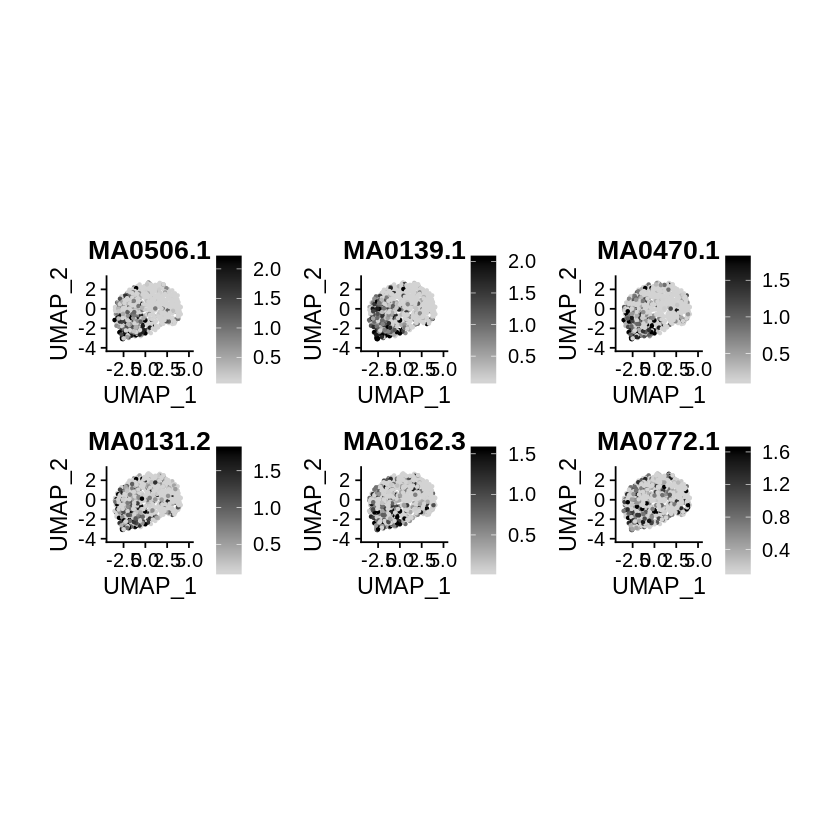

In [75]:
DefaultAssay(LT) <- 'chromvar'

baseplot = FeaturePlot(object = LT,
                          features = c(
                                       'MA0506.1',
                                       'MA0139.1',
                                        "MA0470.1",
                                          'MA0131.2',
                                          'MA0162.3',
                                          'MA0772.1'
                                        ),
                          min.cutoff = 'q10',
                          max.cutoff = 'q90',
                          cols = c('lightgrey', 'black'),
                          pt.size = 0.6,
                          ncol = 3,
                        )
                          


baseplot + coord_fixed(ratio = 0.5) 

In [76]:
ggsave('scATAC_Motifs_up_in_0.pdf', plot = last_plot(), width = 12, height = 5, device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

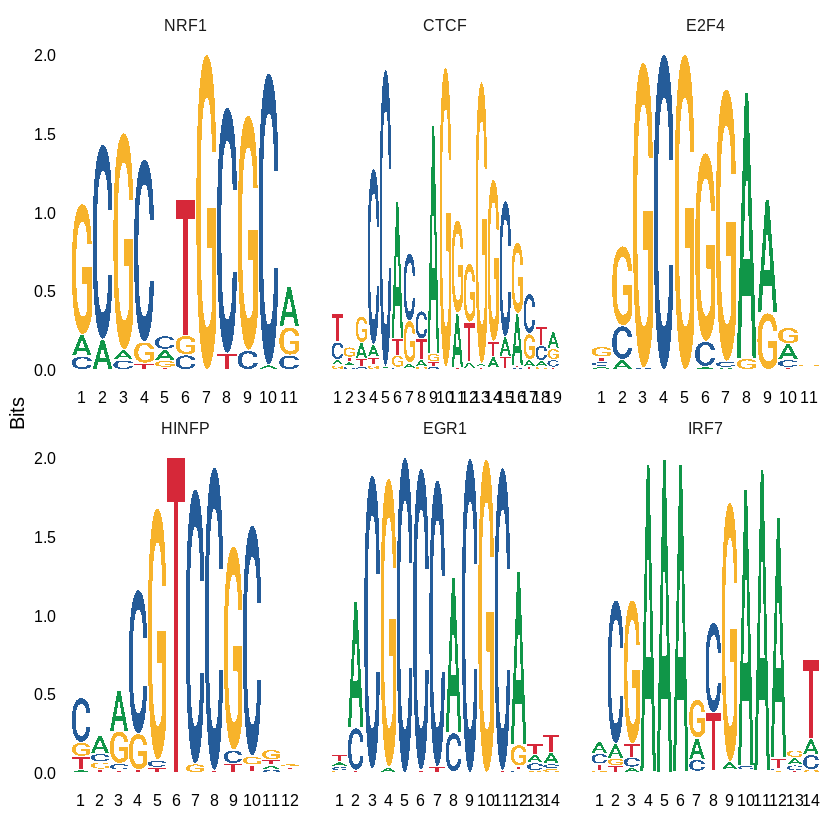

In [77]:
MotifPlot(
  object = LT,
  motifs = c(
               'MA0506.1',
               'MA0139.1',
                "MA0470.1",
                  'MA0131.2',
                  'MA0162.3',
                  'MA0772.1'),
  assay = 'peaks'
)

In [78]:
ggsave('scATAC_Motifnames_up_in_0.pdf', plot = last_plot(), width = 10, height = 3, device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


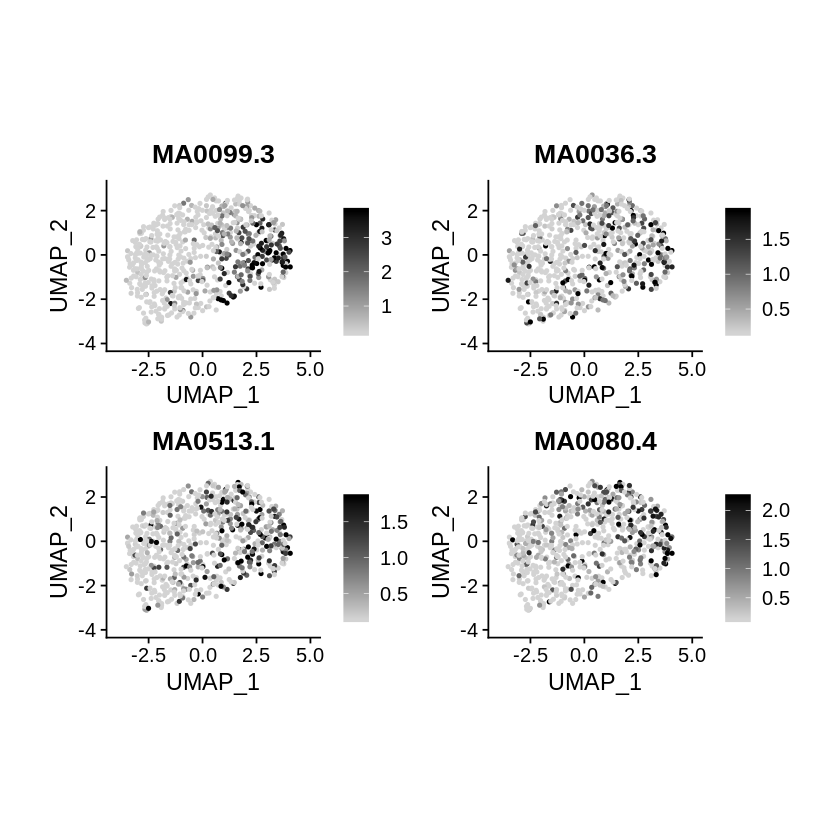

In [79]:
baseplot = FeaturePlot(
  object = LT,
  features = c(
               'MA0099.3',
               'MA0036.3',
               "MA0513.1",
                "MA0080.4"
                ),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  cols = c('lightgrey', 'black'),
  pt.size = 0.8,
  ncol = 2,
)

baseplot + coord_fixed(ratio = 0.75) 

In [80]:
ggsave('scATAC_Motifs_up_in_2.pdf', plot = last_plot(), width = 7.5, height = 6.67, device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

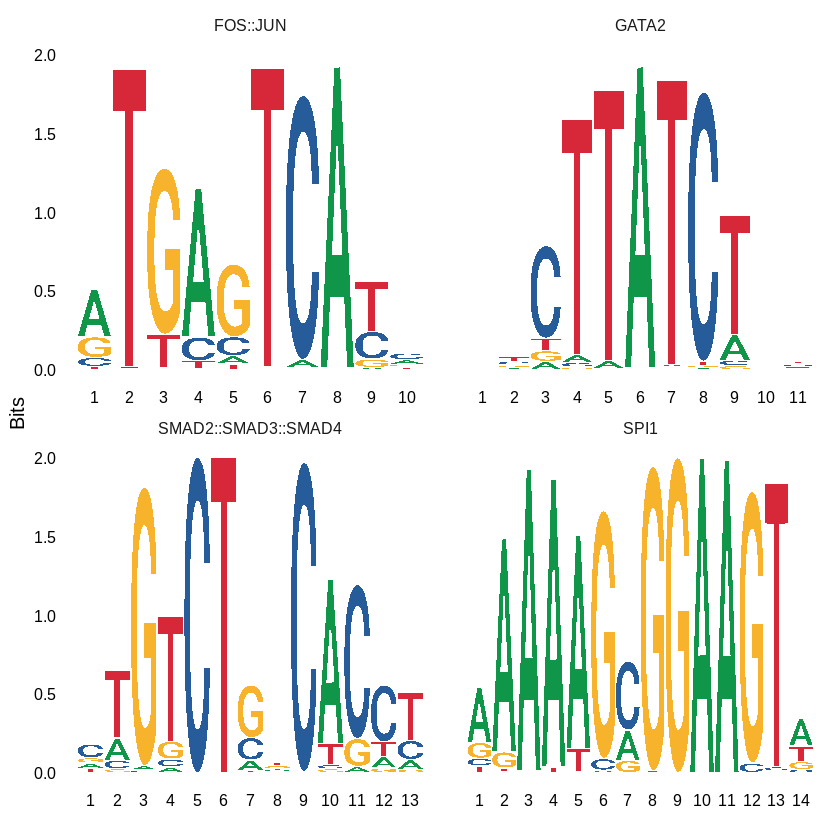

In [81]:
MotifPlot(
  object = LT,
  motifs = c(
               'MA0099.3',
               'MA0036.3',
               "MA0513.1",
                "MA0080.4"),
  assay = 'peaks'
)

In [82]:
ggsave('scATAC_Motifnames_up_in_2.pdf', plot = last_plot(), width = 6, height = 3, device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

In [83]:
# save a number of .csvs
write.csv(LT.markers %>% filter(p_val_adj < 0.05),'./write/LT_markers.csv')

# enriched Motifs in clusters
write.csv(differential.activity_0vs2 %>% filter(p_val_adj < 0.05),'./write/motifs_0vs2.csv')
write.csv(differential.activity_0vs1 %>% filter(p_val_adj < 0.05),'./write/motifs_0vs1.csv')
write.csv(differential.activity_1vs2 %>% filter(p_val_adj < 0.05),'./write/motifs_1vs2.csv')

#peaks and genes file
write.csv(peaks_all_df,'./write/LT_peaks_genes.csv')

In [84]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BSgenome.Mmusculus.UCSC.mm10_1.4.0 BSgenome_1.54.0                   
 [3] rtracklayer_1.46.0                 Biostrings_2.54.0                 
 [5] XVector_0.26.0                     forcats_0.4.0                     
 [7] stringr_1.4.0                      dplyr_0.8.4                       
 